In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet
from lib.sampling import get_slides
from SlideRunner.dataAccess.annotations import AnnotationType
size=512
path = Path('./')

database = Database()
database.open(str(path/'./TUPAC_stitched.sqlite'))

import random
random.seed(42)
slides = [x[0] for x in database.execute('SELECT uid from Slides').fetchall()]


import pickle
sets = pickle.load(open('TUPAC_Trainingset_Folds.p','rb'))


fold = 2
slidelist_test = sets['test'][fold]+1
slidelist_trainval = sets['training'][fold]+1
slidelist_val = random.sample(slidelist_trainval.tolist(),10)


## Split dataset into train/validation and test on slide level

Convert database into in-memory object

In [2]:
def sampling_func(y, **kwargs):
    y_label = np.array(y[1])
    h, w = kwargs['size']

    _arbitrary_prob = 0.1
    _mit_prob = 0.9
    
    sample_prob = np.array([_arbitrary_prob,  _mit_prob])
    
    case = np.random.choice(2, p=sample_prob)
    
    
    
    bg_label = [0] if y_label.dtype == np.int64 else ["bg"]
    classes = bg_label + kwargs['classes']
    level_dimensions = kwargs['level_dimensions']
    level = kwargs['level']
    if ('bg_label_prob' in kwargs):
        _bg_label_prob = kwargs['bg_label_prob']
        if (_bg_label_prob>1.0):
            raise ValueError('Probability needs to be <= 1.0.')
    else:
        _bg_label_prob = 0.0  # add a backgound label to sample complete random
    
    if ('strategy' in kwargs):
        _strategy = kwargs['strategy']
    else:
        _strategy = 'normal'
        
    if ('set' in kwargs):
        _set = kwargs['set']
    else:
        _set = 'training'

        
    _random_offset_scale = 0.5  # up to 50% offset to left and right of frame
    xoffset = randint(-w, w) * _random_offset_scale
    yoffset = randint(-h, h) * _random_offset_scale
    coords = np.array(y[0])

    slide_width, slide_height = level_dimensions[level]
    
    if (case==0):
        xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), slide_height - h)
    if (case==1): # mitosis
        
        ids = y_label == 1

        if (_set == 'training'):
            ids[coords[:,1]>slide_height/2] = 0 # lower part not allowed
        elif (_set == 'validation'):
            ids[coords[:,1]<slide_height/2] = 0 # upper part not allowed

        if (np.count_nonzero(ids)<1):
            xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), slide_height - h)
        else:
            xmin, ymin, xmax, ymax = np.array(y[0])[ids][randint(0, np.count_nonzero(ids) - 1)]

    return int(xmin - w / 2 + xoffset), int(ymin - h / 2 +yoffset)


def get_slides(slidelist_test:list, database:"Database", positive_class:int=1, negative_class:int=7, basepath:str='WSI', slidelist_val:list=[], size:int=256):


    lbl_bbox=list()
    files=list()
    train_slides=list()
    val_slides=list()

    getslides = """SELECT uid, directory,filename FROM Slides"""
    for idx, (currslide, direct, filename) in enumerate(tqdm(database.execute(getslides).fetchall(), desc='Loading slides .. ')):
        if (str(currslide) in slidelist_test): # skip test slides
            continue

        database.loadIntoMemory(currslide)

        slide_path = basepath + os.sep + filename

        slide = openslide.open_slide(str(slide_path))

        level = 0#slide.level_count - 1
        level_dimension = slide.level_dimensions[level]
        down_factor = slide.level_downsamples[level]

        classes = {positive_class: 1} # Map non-mitosis to background

        labels, bboxes = [], []
        annotations = dict()
        for id, annotation in database.annotations.items():
            if annotation.deleted or annotation.annotationType != AnnotationType.SPOT:
                continue
            annotation.r = 25
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            if annotation.agreedClass not in annotations:
                annotations[annotation.agreedClass] = dict()
                annotations[annotation.agreedClass]['bboxes'] = list()
                annotations[annotation.agreedClass]['label'] = list()

            annotations[annotation.agreedClass]['bboxes'].append([int(x_min), int(y_min), int(x_max), int(y_max)])
            annotations[annotation.agreedClass]['label'].append(annotation.agreedClass)

            if annotation.agreedClass in classes:
                label = classes[annotation.agreedClass]

                bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
                labels.append(label)

        if len(bboxes) > 0:
            if (len(slidelist_val)==0):
                lbl_bbox.append([bboxes, labels])
                files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='training', negative_class=negative_class)))
                train_slides.append(len(files)-1)

                lbl_bbox.append([bboxes, labels])
                files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='validation', negative_class=negative_class)))
                val_slides.append(len(files)-1)
            else:
                if (currslide not in slidelist_val):
                    lbl_bbox.append([bboxes, labels])
                    files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='training', negative_class=negative_class)))
                    train_slides.append(len(files)-1)
                else:
                    lbl_bbox.append([bboxes, labels])
                    files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='validation', negative_class=negative_class)))
                    val_slides.append(len(files)-1)

    return lbl_bbox, train_slides,val_slides,files


In [3]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, slidelist_val=slidelist_val, negative_class=2, positive_class=1,  
                                                     size=size,database=database,basepath='./TUPACstitched/')

Loading slides .. : 100%|██████████| 73/73 [00:00<00:00, 288.75it/s]


In [4]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [5]:
slidelist_val

[2, 17, 36, 19, 21, 6, 59, 69, 16, 13]

In [6]:
bs = 12
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))


In [7]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.2,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.2,
                      #xtra_tfms=xtra_tfms,
                     )


In [8]:
path

PosixPath('.')

In [9]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min, num_workers=4).normalize()

In [10]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.7087852838341706, 'col_pct': 0.0016912782186294661, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 5}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.5, resolved={'degrees': -33.53808344490158}, do_run=False, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.2), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.5, resolved={'scale': 1.1022846119338956, 'row_pct': 0.38519543334472717, 'col_pct': 0.5765880434965995}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on

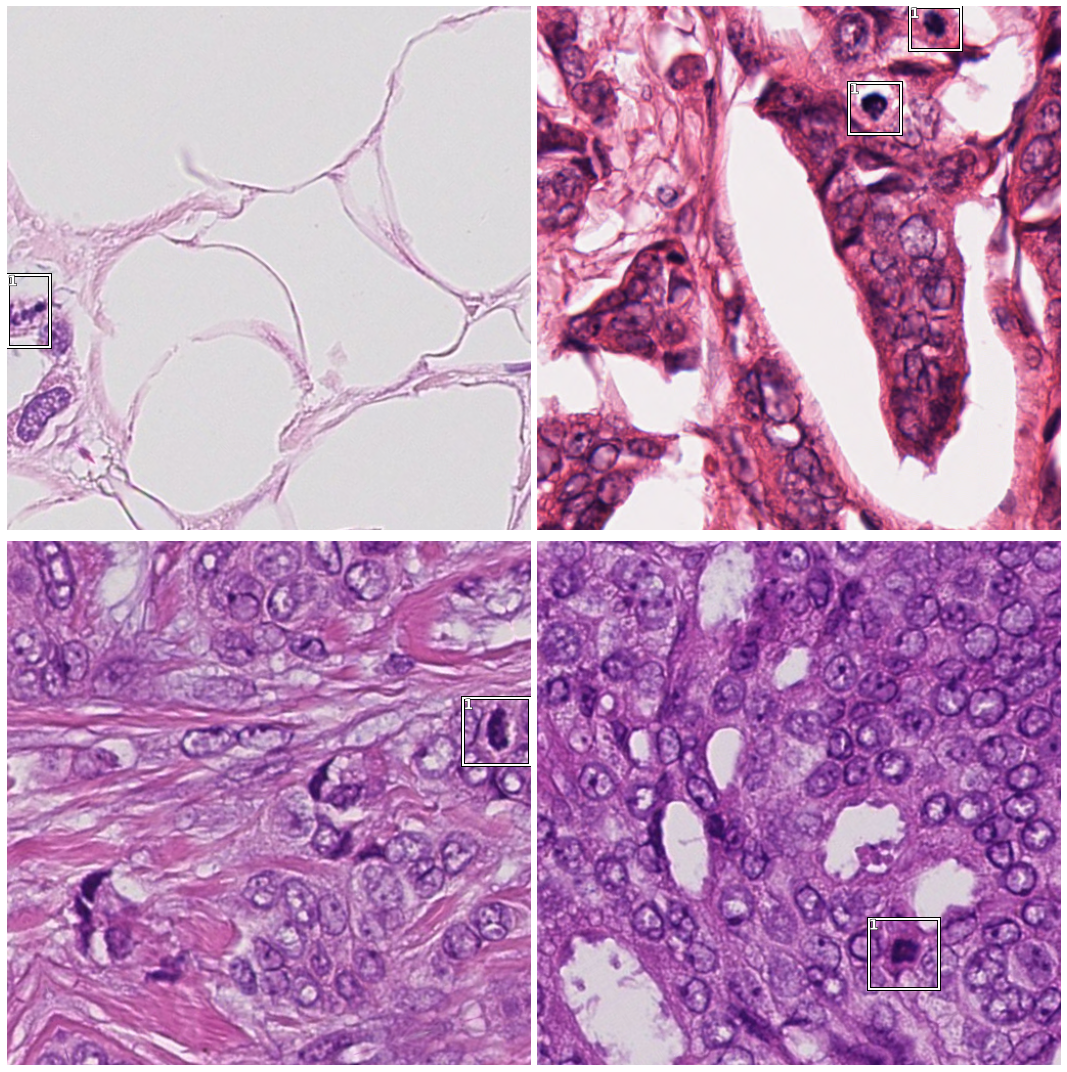

In [12]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(15,15))

In [13]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7,0.8,0.9])


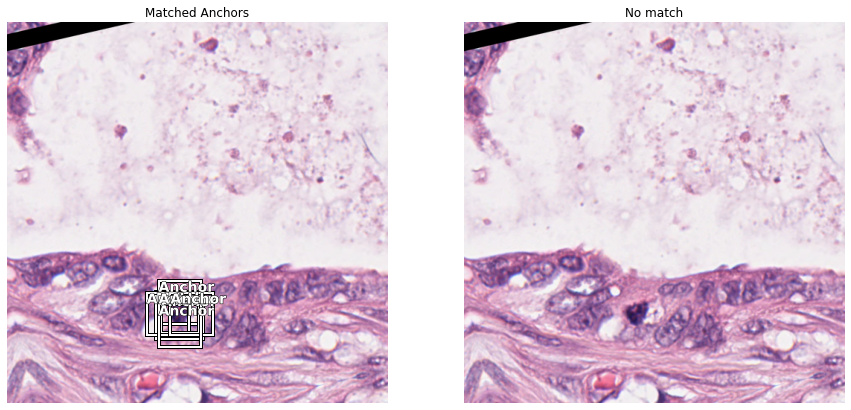

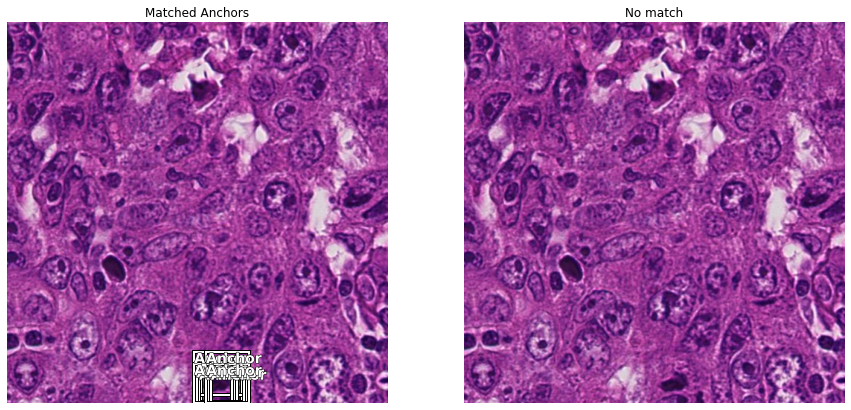

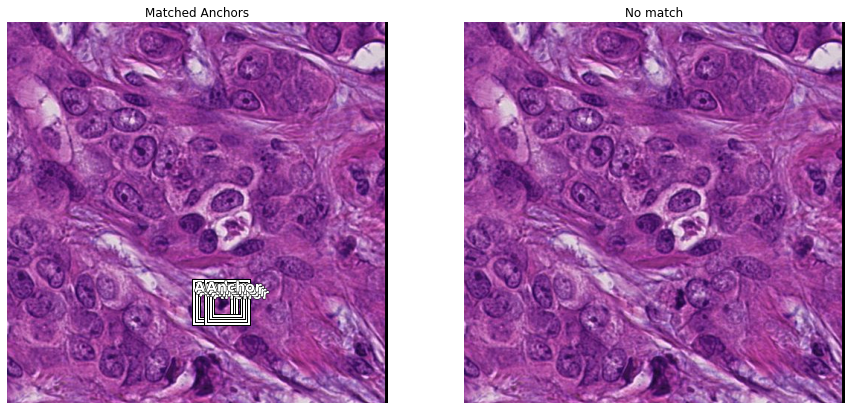

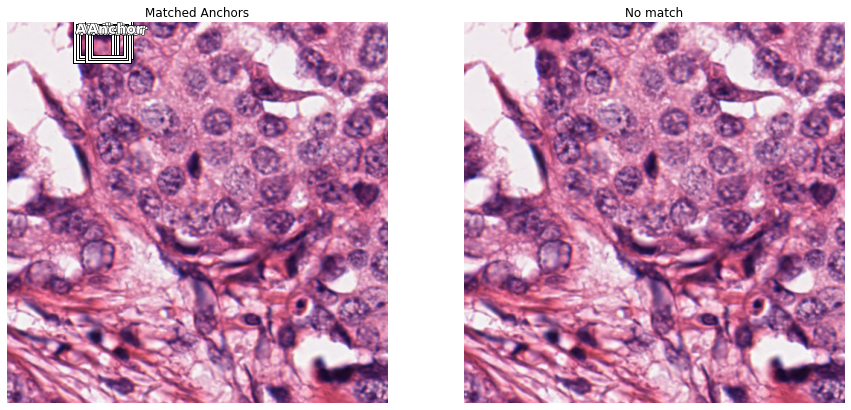

In [14]:
not_found = show_anchors_on_images(data, anchors)

In [15]:
crit = RetinaNetFocalLoss(anchors)

In [16]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=4, sizes=[32], chs=128, final_bias=-4., n_conv=3)



In [17]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [18]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


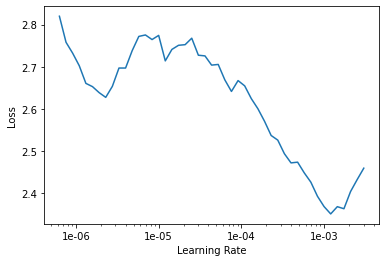

In [19]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 3639/3639 [00:01<00:00, 2362.40it/s]


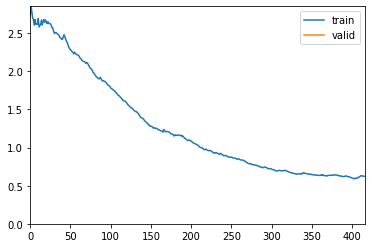

In [20]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 3698/3698 [00:01<00:00, 2244.48it/s]


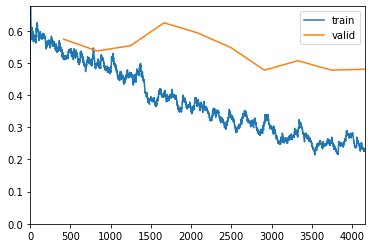

GT: 100%|██████████| 3286/3286 [00:01<00:00, 3252.79it/s]


In [21]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

In [22]:
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

GT: 100%|██████████| 3040/3040 [00:00<00:00, 3900.77it/s]


GT: 100%|██████████| 3294/3294 [00:00<00:00, 3377.99it/s]


GT: 100%|██████████| 3538/3538 [00:01<00:00, 3256.52it/s]


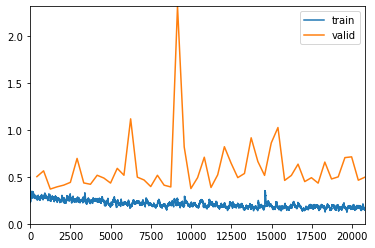

Better model found at epoch 0 with pascal_voc_metric value: 0.7483288165161737.


GT: 100%|██████████| 2428/2428 [00:00<00:00, 4359.36it/s]


Better model found at epoch 6 with pascal_voc_metric value: 0.8911144369622479.


GT: 100%|██████████| 3005/3005 [00:00<00:00, 3931.97it/s]


In [23]:
learn.unfreeze()
lr=1e-4

learn.fit(50, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

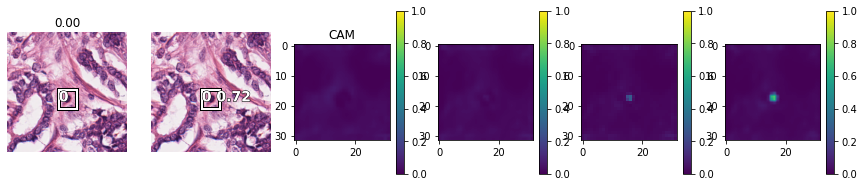

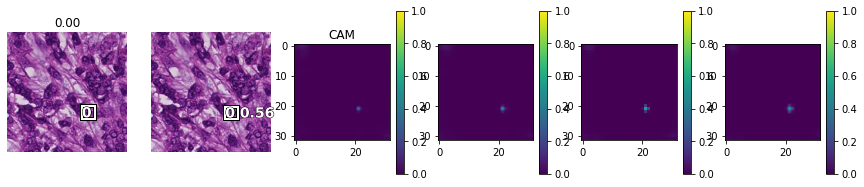

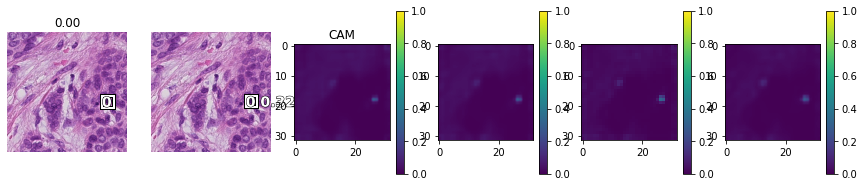

In [24]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [25]:
#learn.save('RetinaNet-TUPAC_AL-OrigSplit-512s', with_opt=True)
learn.export("RetinaNet-TUPAC-CrossValidationTrainingset-Batch3-512s.pth")

In [26]:
#torch.save(learn.model.state_dict(), "RetinaNet-TUPAC_CB-512s-OrigSplit_statedict.pth")

In [27]:
learn.data.stats

[tensor([0.6463, 0.3787, 0.6369]), tensor([0.1754, 0.2033, 0.1490])]

In [28]:
slidelist_test

array([58, 65, 11, 61, 12, 72, 35, 62, 56, 47, 22, 57, 45, 20, 55,  3, 39,  7, 44, 46,  4, 71, 63, 18])

In [29]:
pickle.dump(slidelist_test,open('slidelist_test_TUPAC_CrossValidataion_batch3.p','wb'))

In [30]:
slidelist_trainval

array([41, 36, 48, 51, 38, 13, 69, 17, 59, 64, 29, 43, 30, 49,  6, 21, 52, 19, 60, 25, 23, 34, 32, 26,  5, 42, 14, 27,
       50, 66, 70, 31, 10,  8, 16, 37,  1, 68, 53,  9,  2, 73, 15, 67, 40, 28, 54, 24, 33])